In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import backtesting as bt

## data

In [8]:
# 收开盘价数据
close = pd.read_pickle(r"E:\2023Spring\Algorithmic Trading\factors\data\adj_close.pk")
openp = pd.read_pickle(r"E:\2023Spring\Algorithmic Trading\factors\data\adj_open.pk")
Close = pd.read_pickle(r"E:\2023Spring\Algorithmic Trading\factors\data\close.pk")

In [9]:
# 换手率计算相关数据
total_turnover = pd.read_pickle(r"E:\2023Spring\Algorithmic Trading\factors\data\total_turnover.pk") #成交额
total_a = pd.read_pickle(r"E:\2023Spring\Algorithmic Trading\factors\data\total_a.pk") #总股数

In [10]:
# 红利数据
asharedividend = pd.read_pickle(r"E:\2023Spring\Algorithmic Trading\factors\data\asharedividend.pk")

## Factors

### tr20_inver

In [37]:
turnover_rate = total_turnover/(total_a*Close) #换手率
tr20_inver = 1/turnover_rate.rolling(window = 20,min_periods = 10).std()

### dvd_rate

In [43]:
#取出流通股分红数据
dvd_circulation = asharedividend[~asharedividend['S_DIV_OBJECT'].isin(['A股限售股','重整管理人','国家股股东'])]

# 以除权除息日为红利信息公告日期
dvd_exdt = dvd_circulation[['S_INFO_WINDCODE','S_DIV_PROGRESS','CASH_DVD_PER_SH_PRE_TAX','CASH_DVD_PER_SH_AFTER_TAX','EX_DT']]

#转换日期格式
dvd_exdt.loc[:,'EX_DT'] = pd.to_datetime(dvd_exdt.loc[:,'EX_DT'],format = '%Y%m%d')
dvd_exdt = dvd_exdt.infer_objects()
dvd_exdt = dvd_exdt[~dvd_exdt['EX_DT'].isna()].drop_duplicates()

#处理重复值
dvd_exdt = dvd_exdt[["S_INFO_WINDCODE","CASH_DVD_PER_SH_PRE_TAX",'EX_DT']]
dvd_exdt = dvd_exdt.groupby(["S_INFO_WINDCODE",'EX_DT']).sum().reset_index()

# 取出每股税前股息数据
dvd_pre = pd.pivot(dvd_exdt, columns = 'S_INFO_WINDCODE',index = 'EX_DT',values = 'CASH_DVD_PER_SH_PRE_TAX')
dvd_pre.columns = dvd_pre.columns.map(lambda x:x[:-3]) #提取股票代码的数字部分
dvdpre_TTM = (dvd_pre*np.sign(close)).rolling(window = "365D").sum()

In [44]:
# 过去一年股息和所计算的股息率
dvd_rate_TTM = dvdpre_TTM/close 

## Correlation matrix

In [51]:
dvd_rate_TTM.corrwith(tr20_inver,axis = 1).describe()

count    2067.000000
mean        0.209470
std         0.121834
min        -1.000000
25%         0.179517
50%         0.218474
75%         0.254019
max         1.000000
dtype: float64

## Backtesting

## IC

In [52]:
factor = bt.factor_process(tr20_inver).dropna(how = 'all')
o1o2 = openp.shift(-2)/openp.shift(-1) - 1
ic_series = factor.rank(axis = 1).corrwith(o1o2, axis = 1)
ICIR = ic_series.mean()/ic_series.std()
rankic_series = factor.rank(axis = 1).corrwith(o1o2.rank(axis = 1), axis = 1)

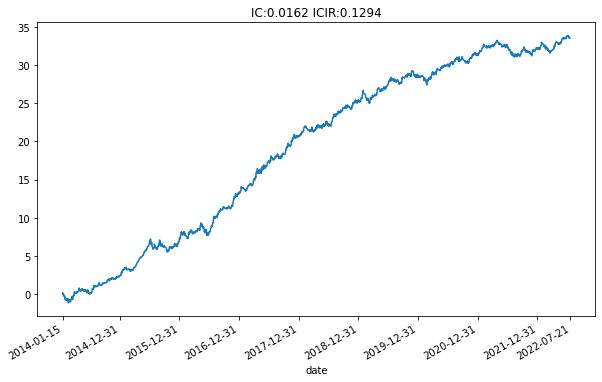

In [53]:
# 累计IC收益图

# 生成中间日期
middle_dates = pd.date_range(start=factor.index[0], end=factor.index[-1], freq='1YE')
# 设置x轴标签显示第一天、最后一天和中间日期
xticks = [factor.index[0]] + list(middle_dates) + [factor.index[-1]]

ic_series.cumsum().plot(figsize=(10,6),
                        title = "IC:"+str(ic_series.mean().round(4))+" "+"ICIR:"+str(ICIR.round(4)), 
                        xticks = xticks)
plt.show()

## PnL

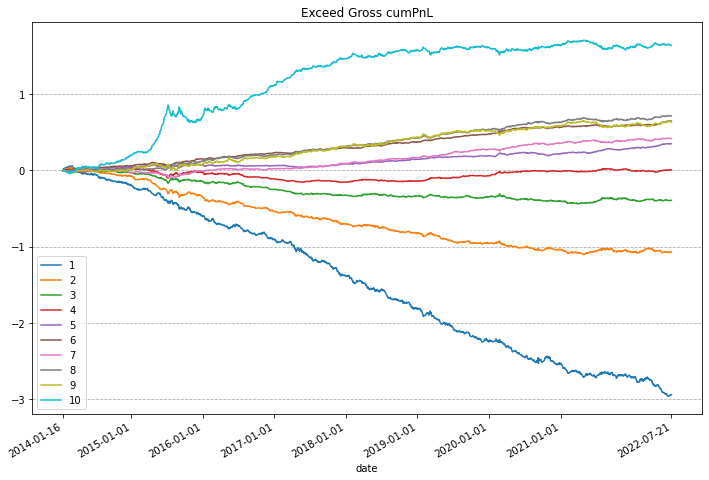

In [41]:
tr20_inver_btest = bt.group_test(tr20_inver)
tr20_inver_btest.group(10)
bt.plot(tr20_inver_btest.Exceed_ret.cumsum())

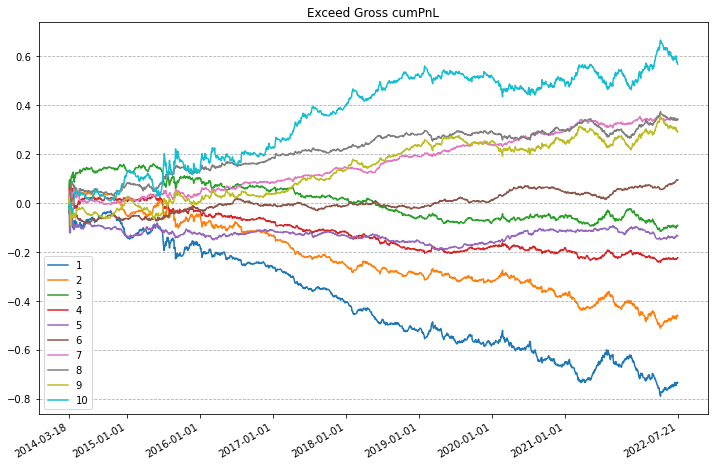

In [49]:
dvd_rate_TTM_btest = bt.group_test(dvd_rate_TTM)
dvd_rate_TTM_btest.group(10)
bt.plot(dvd_rate_TTM_btest.Exceed_ret.cumsum())

## Sharp Ratio

In [42]:
bt.outcome(tr20_inver_btest.Exceed_ret, tr20_inver_btest.Exceed_ret_net, tr20_inver_btest.group_tor)

C:\Users\小何\AppData\Roaming\Python\Python39\site-packages\numpy\core\fromnumeric.py:3643: FutureWarning: The behavior of DataFrame.std with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return std(axis=axis, dtype=dtype, out=out, ddof=ddof, **kwargs)


,return,Sharp,return_net,Sharp_net,turnover
1,-0.346,-3.025,-0.381,-3.324,0.117
2,-0.127,-1.940,-0.205,-3.144,0.269
3,-0.046,-1.033,-0.151,-3.347,0.355
4,0.001,0.016,-0.120,-3.430,0.411
5,0.041,1.443,-0.089,-3.096,0.446
6,0.076,2.581,-0.058,-1.948,0.456
7,0.049,1.410,-0.081,-2.302,0.445
8,0.084,1.897,-0.034,-0.769,0.403
9,0.075,1.275,-0.017,-0.289,0.312
10,0.193,1.909,0.152,1.509,0.139


In [50]:
bt.outcome(dvd_rate_TTM_btest.Exceed_ret, dvd_rate_TTM_btest.Exceed_ret_net, dvd_rate_TTM_btest.group_tor)

C:\Users\小何\AppData\Roaming\Python\Python39\site-packages\numpy\core\fromnumeric.py:3643: FutureWarning: The behavior of DataFrame.std with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return std(axis=axis, dtype=dtype, out=out, ddof=ddof, **kwargs)


,return,Sharp,return_net,Sharp_net,turnover
1,-0.088,-1.220,-0.103,-1.425,0.020
2,-0.055,-0.993,-0.083,-1.491,0.038
3,-0.011,-0.193,-0.047,-0.830,0.050
4,-0.027,-0.530,-0.068,-1.340,0.056
5,-0.016,-0.348,-0.061,-1.306,0.062
6,0.011,0.263,-0.034,-0.785,0.061
7,0.041,1.125,-0.000,-0.010,0.057
8,0.041,0.911,0.005,0.112,0.048
9,0.035,0.601,0.006,0.097,0.039
10,0.068,0.792,0.053,0.620,0.022
